In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import xarray as xr
xr.__version__

'0.15.0'

In [3]:
import sys
a2emmc_path = '/home/equon/a2e-mmc'
if not a2emmc_path in sys.path:
    sys.path.append(a2emmc_path)
from mmctools.wrf.utils import Tower, combine_towers
from mmctools.wrf.ts import read_tslist, Toof
from mmctools.plotting import plot_timeheight, plot_profile, plot_timehistory_at_height

# Process tslist output
Notes:
- `TS` is a surface time series
- `PH` is elevation (instead of perturbation geopotential)
- `UU`, `VV`, `WW` are velocities [m/s]
- `PR` is pressure [Pa]

In [4]:
# WRF inputs
#wrfcasedir = '/Users/equon/MMC/SWIFTRegion/SWIFT_2013110800_GFS'
wrfcasedir = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS'
towerdir = '/projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/towers'

# from namelist.input:
domain = 3
Nlevels = 88 # `max_ts_level` 
Nlat,Nlon = 11,11
starttime = '2013-11-08 00:00' # `start_*`
dt = 10.0 # time step (and output frequency) [s]
dx = 3000.0 # grid spacing [m]

In [5]:
# constant heights to interpolate data to
spacing = 10. # microscale grid [m]
heights = np.arange(0,2000+spacing,spacing)

In [6]:
# reference location: TTU tower
TTU_latlon = (33.61056, -102.05056)

In [7]:
# selected sampling towers
selected_towers = [
    't0051', 't0062', 't0073',
    't0050', 't0061', 't0072',
    't0049', 't0060', 't0071',
]

## load array of tslist virtual "towers"

In [8]:
tslist = read_tslist(os.path.join(wrfcasedir,'tslist'),
                     convert_to_xy='utm',latlon_ref=TTU_latlon)
tslist

,name,prefix,lat,lon,x,y
0,tower0001,t0001,33.4755,-102.2123,-14608.410971,-15397.405026
1,tower0002,t0002,33.5025,-102.2123,-14688.876318,-12402.550449
2,tower0003,t0003,33.5295,-102.2124,-14778.688938,-9407.935748
3,tower0004,t0004,33.5565,-102.2124,-14859.266512,-6413.061307
4,tower0005,t0005,33.5834,-102.2125,-14948.886780,-3429.519106
...,...,...,...,...,...,...
116,tower0117,t0117,33.6374,-101.8885,14952.418825,3418.309506
117,tower0118,t0118,33.6644,-101.8884,14871.470529,6413.841873
118,tower0119,t0119,33.6914,-101.8884,14781.178934,9409.104064
119,tower0120,t0120,33.7183,-101.8883,14700.428425,12393.561642


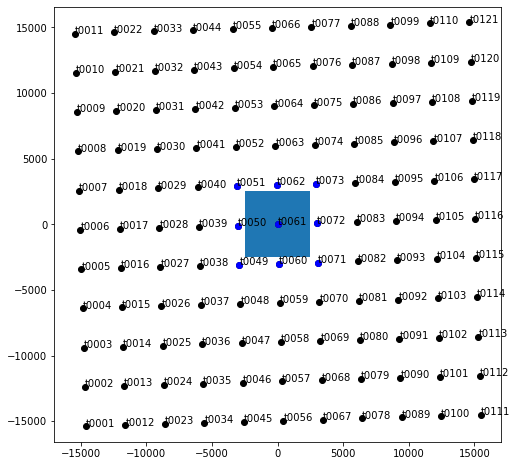

In [9]:
fig,ax = plt.subplots(figsize=(8,8))
ax.plot(tslist['x'],tslist['y'],'ko')
for tow in selected_towers:
    tow = tslist.loc[tslist['prefix']==tow]
    ax.plot(tow['x'],tow['y'],'bo')
for i,tow in tslist.iterrows():
    ax.text(tow['x'],tow['y'],tow['prefix'])
ax.axis('equal')
rect = patches.Rectangle((-2500,-2500),5000,5000)
ax.add_patch(rect)

In [10]:
# %%time
# ds = combine_towers(towerdir,
#                     restarts=None,
#                     simulation_start=starttime,
#                     fname=[tow+'.d03' for tow in selected_towers],
#                     dx=dx, dy=dx,
#                     height_var='ph', heights=heights, agl=True,
#                     # kwargs to Tower.to_dataframe():
#                     unstagger=True)
# ds.to_netcdf('combined_towers.nc')

# CPU times: user 1min 49s, sys: 9.36 s, total: 1min 58s
# Wall time: 2min 10s

In [11]:
ds = xr.open_dataset('combined_towers.nc')

In [12]:
ds

<xarray.Dataset>
Dimensions:   (datetime: 21600, nx: 3, ny: 3, nz: 201)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-11-08T00:00:10 ... 2013-11-10T12:00:00
    lat       (ny, nx) float64 ...
    lon       (ny, nx) float64 ...
    zsurface  (ny, nx) float64 ...
    x         (ny, nx) float64 ...
    y         (ny, nx) float64 ...
    z         (nz) float64 ...
Dimensions without coordinates: nx, ny, nz
Data variables:
    theta     (datetime, nz, ny, nx) float64 ...
    pr        (datetime, nz, ny, nx) float64 ...
    w         (datetime, nz, ny, nx) float64 ...
    qv        (datetime, nz, ny, nx) float64 ...
    u         (datetime, nz, ny, nx) float64 ...
    v         (datetime, nz, ny, nx) float64 ...
    t2        (datetime, ny, nx) float64 ...
    q2        (datetime, ny, nx) float64 ...
    u10       (datetime, ny, nx) float64 ...
    v10       (datetime, ny, nx) float64 ...
    psfc      (datetime, ny, nx) float64 ...
    lwd       (datetime, ny, nx) float64 ...
    swd       (datetime, ny, nx) float64 ...
    hfx       (datetime, ny, nx) float64 ...
    lfx       (datetime, ny, nx) float64 ...
    tsk       (datetime, ny, nx) float64 ...
    slttop    (datetime, ny, nx) float64 ...
    rainc     (datetime, ny, nx) float64 ...
    rainnc    (datetime, ny, nx) float64 ...
    clw       (datetime, ny, nx) float64 ...
    wspd      (datetime, nz, ny, nx) float64 ...
    wdir      (datetime, nz, ny, nx) float64 ...
Attributes:
    DX:            3000.0
    DY:            3000.0
    CREATED_FROM:  /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/towers

In [13]:
# calculate at center column i,j = (1,1)
dpdx = (ds['pr'][:,:,1,2] - ds['pr'][:,:,1,0]) / (2*ds.attrs['DX'])
dpdx = dpdx.assign_coords(nz=heights).to_dataframe()['pr']
dpdx.name = 'dp/dx'

In [14]:
# calculate at center column i,j = (1,1)
dpdy = (ds['pr'][:,:,2,1] - ds['pr'][:,:,0,1]) / (2*ds.attrs['DX'])
dpdy = dpdy.assign_coords(nz=heights).to_dataframe()['pr']
dpdy.name = 'dp/dy'

In [15]:
driving_gradient = pd.concat((dpdx,dpdy), axis=1)
rounded_datetimes = driving_gradient.index.levels[0].round(freq='1s')
driving_gradient.index.set_levels(rounded_datetimes, level=0, inplace=True)
driving_gradient.index.set_names('height', level=1, inplace=True)
driving_gradient['PGFx'] = -driving_gradient['dp/dx']
driving_gradient['PGFy'] = -driving_gradient['dp/dy']

Text(0.5, 0, '$dp/dy$')

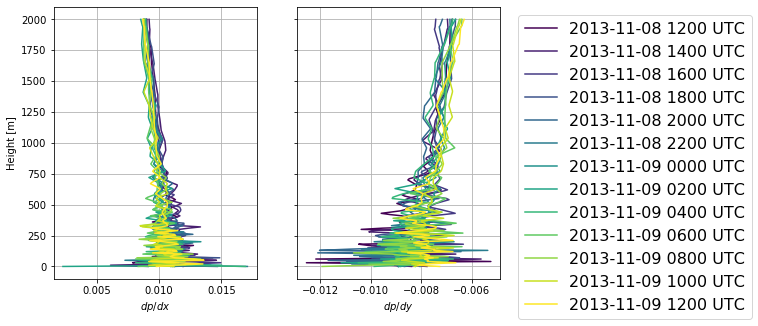

In [16]:
selected_times = pd.date_range('2013-11-08 12:00', '2013-11-09 12:00', freq='2h')
fig,ax = plot_profile(driving_gradient,
                      fields=['dp/dx','dp/dy'],
                      times=selected_times,
                      cmap='viridis')
ax[0].set_xlabel('$dp/dx$')
ax[1].set_xlabel('$dp/dy$')

In [17]:
%%time
from mmctools.dataloaders import read_dir
from mmctools.wrf.utils import extract_column_from_wrfdata
wrf = read_dir(os.path.join(wrfcasedir,'auxout'),
               file_filter='mmc_d03_*',
               reader=extract_column_from_wrfdata,
               verbose=True,
               coords=TTU_latlon,
               #spatial_filter='interpolate',L_filter=0.0,
               spatial_filter='nearest',
               Ztop=2000.0,Vres=5.0,
               additional_fields=['P','PB'],
              )

# CPU times: user 35.5 s, sys: 22.3 s, total: 57.8 s
# Wall time: 3min 22s

Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_00:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_01:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_02:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_03:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_04:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_05:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_06:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_07:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_08:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_09:00:00
Reading /projects/mmc/SWIFTRegion/SWIFT_2013110800_GFS/auxout/mmc_d03_2013-11-08_10:00:00
Reading /p

In [18]:
wrf

<xarray.Dataset>
Dimensions:       (Time: 361, height: 401)
Coordinates:
  * height        (height) float64 0.0 5.0 10.0 ... 1.99e+03 1.995e+03 2e+03
  * Time          (Time) datetime64[ns] 2013-11-08 ... 2013-11-10T12:00:00
Data variables:
    U10           (Time) float32 0.47599 0.19477205 ... -1.625941 -1.611402
    V10           (Time) float32 4.9222927 3.5544748 ... -2.3043504 -2.3336682
    T2            (Time) float32 284.73062 283.01917 ... 279.0249 278.94742
    TSK           (Time) float32 282.5096 281.33322 ... 278.30835 278.24094
    UST           (Time) float32 1e-04 0.20592426 ... 0.15314361 0.15612061
    PSFC          (Time) float32 91081.086 91096.76 ... 90944.13 90946.74
    HFX           (Time) float32 0.0 -32.80634 ... -11.05214 -11.157763
    LH            (Time) float32 0.0 10.31907 6.957901 ... -6.189477 -6.214908
    MUU           (Time) float32 0.0 81060.33 81038.13 ... 80817.29 80820.195
    MUV           (Time) float32 0.0 81059.9 81037.734 ... 80816.59 80819.54
    MUT           (Time) float32 0.0 81060.43 81038.25 ... 80817.2 80820.05
    U             (Time, height) float64 0.0 0.491 0.5068 ... -1.408 -1.382
    V             (Time, height) float64 0.0 5.054 5.187 ... 1.141 1.176 1.212
    W             (Time, height) float64 0.0 0.002937 ... 0.01613 0.01619
    theta         (Time, height) float64 282.5 292.6 292.7 ... 305.8 305.8 305.9
    RU_TEND       (Time, height) float64 0.0 0.0 0.0 0.0 ... -3.78 -3.03 -2.28
    RU_TEND_ADV   (Time, height) float64 0.0 0.0 0.0 ... -11.19 -11.37 -11.55
    RU_TEND_PGF   (Time, height) float64 0.0 0.0 0.0 0.0 ... 0.5136 1.225 1.937
    RU_TEND_COR   (Time, height) float64 0.0 0.0 0.0 0.0 ... 6.723 6.937 7.152
    RU_TEND_PHYS  (Time, height) float64 0.0 0.0 0.0 ... 0.1756 0.1801 0.1846
    RV_TEND       (Time, height) float64 0.0 0.0 0.0 0.0 ... -1.62 -2.023 -2.426
    RV_TEND_ADV   (Time, height) float64 0.0 0.0 0.0 ... -11.61 -11.49 -11.37
    RV_TEND_PGF   (Time, height) float64 0.0 0.0 0.0 0.0 ... 1.271 0.9142 0.5572
    RV_TEND_COR   (Time, height) float64 0.0 0.0 0.0 0.0 ... 8.706 8.542 8.379
    RV_TEND_PHYS  (Time, height) float64 0.0 0.0 0.0 ... 0.01664 0.01486 0.01307
    T_TEND_ADV    (Time, height) float64 0.0 0.0 0.0 0.0 ... -4.904 -4.94 -4.976
    P             (Time, height) float64 2.47e+03 2.469e+03 ... 1.45e+03
    PB            (Time, height) float64 8.859e+04 8.856e+04 ... 6.997e+04

In [19]:
wrf['PGFx'] = wrf['RU_TEND_PGF'] / wrf['MUU']
wrf['PGFy'] = wrf['RV_TEND_PGF'] / wrf['MUV']
wrf['ADVx'] = wrf['RU_TEND_ADV'] / wrf['MUU']
wrf['ADVy'] = wrf['RV_TEND_ADV'] / wrf['MUV']
wrf['Fu'] = wrf['PGFx'] + wrf['ADVx']
wrf['Fv'] = wrf['PGFy'] + wrf['ADVy']

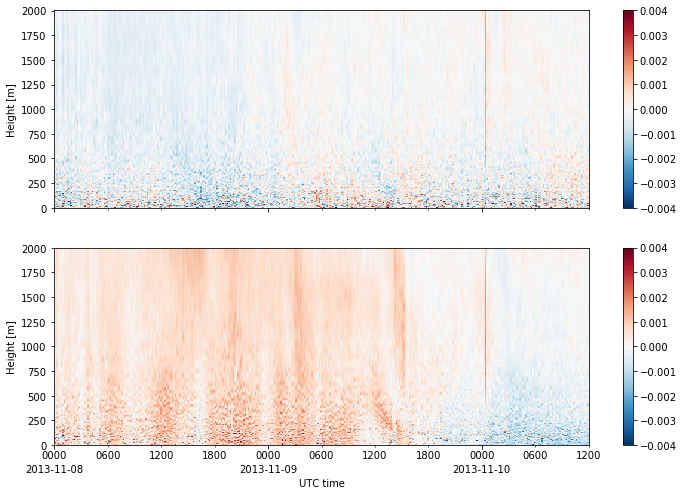

In [20]:
fig,ax,cb = plot_timeheight(wrf,fields=['PGFx','PGFy'],
                            fieldlimits={'PGFx':(-.004,.004),'PGFy':(-.004,.004)},
                            cmap='RdBu_r')
# fig.suptitle('pressure-gradient force')
fig.savefig('WRF_PGF_noavg.png',dpi=150,bbox_inches='tight')

# fig,ax,cb = plot_timeheight(wrf,fields=['ADVx','ADVy'])
# fig.suptitle('advective tendencies')

# #fig,ax,cb = plot_timeheight(wrf,fields=['MUU','MUV'])
# # MU* doesn't have any height dependence
# fig,ax = plt.subplots()
# mu = wrf[['MUU','MUV']].isel(Time=slice(1,None))
# mu['MUU'].plot()
# mu['MUV'].plot()

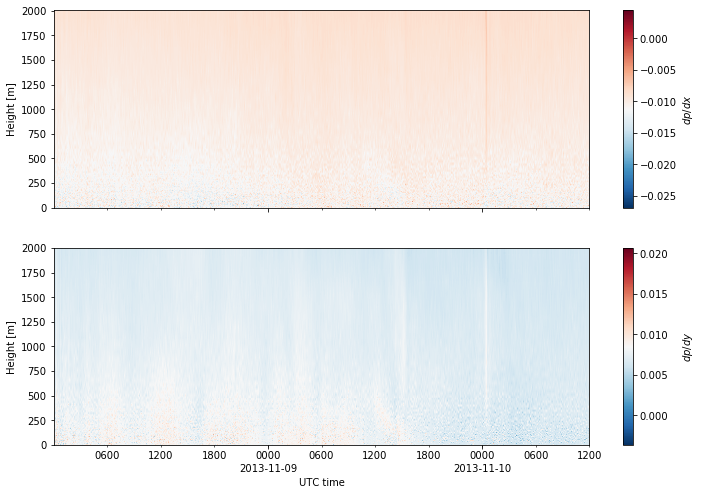

In [21]:
fig,ax,cb = plot_timeheight(driving_gradient,
                            fields=['PGFx','PGFy'],
                            #fieldlimits={'dp/dx':(-.004,.004),'dp/dy':(-.004,.004)},
                            cmap='RdBu_r')
cb[0].set_label('$dp/dx$')
cb[1].set_label('$dp/dy$')

In [22]:
driving_gradient_shifted = driving_gradient[['PGFx','PGFy']].copy()
meanvals_1000m = driving_gradient.mean(level=1).xs(1000)
driving_gradient_shifted['PGFx'] -= meanvals_1000m['PGFx']
driving_gradient_shifted['PGFy'] -= meanvals_1000m['PGFy']

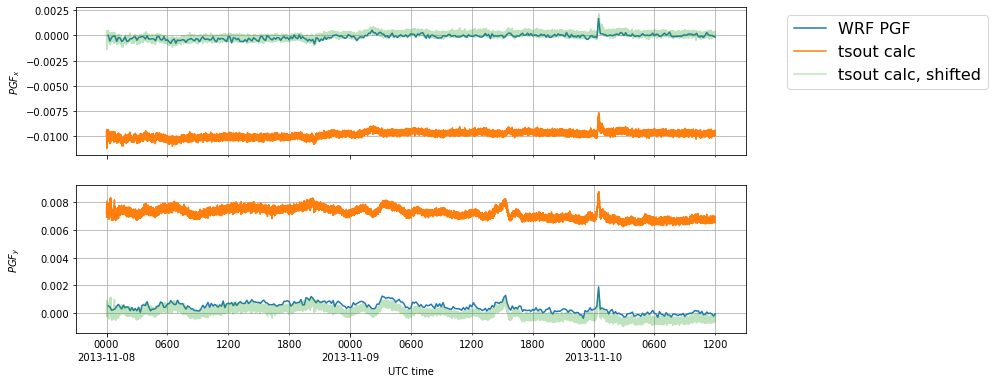

In [23]:
fig,ax = plot_timehistory_at_height(
    {
        'WRF PGF':wrf,
        'tsout calc':driving_gradient,
        'tsout calc, shifted':driving_gradient_shifted,
    },
    fields=['PGFx','PGFy'],
    heights=1000.,
    datasetkwargs={'tsout calc, shifted':dict(alpha=0.3)},
)
ax[0].set_ylabel('$PGF_x$')
ax[1].set_ylabel('$PGF_y$')
fig.savefig('estimated_pgf.png',bbox_inches='tight')

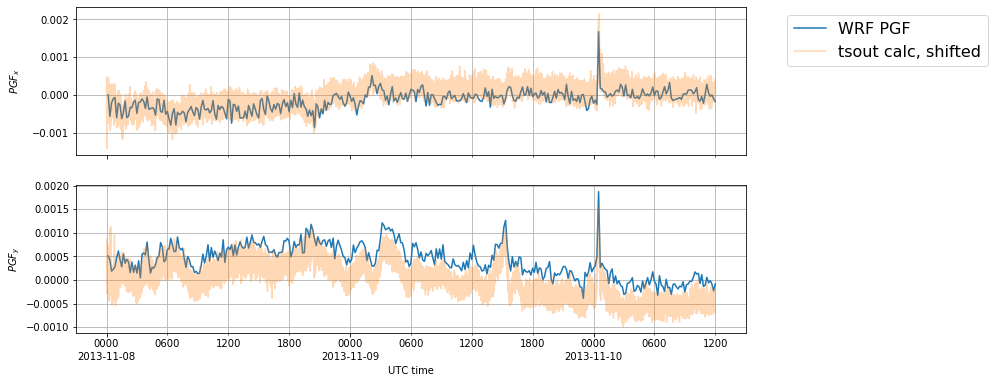

In [24]:
fig,ax = plot_timehistory_at_height(
    {
        'WRF PGF':wrf,
        #'tsout calc':driving_gradient,
        'tsout calc, shifted':driving_gradient_shifted,
    },
    fields=['PGFx','PGFy'],
    heights=1000.,
    datasetkwargs={'tsout calc, shifted':dict(alpha=0.3)},
)
ax[0].set_ylabel('$PGF_x$')
ax[1].set_ylabel('$PGF_y$')
fig.savefig('estimated_pgf_shiftedonly.png',bbox_inches='tight')

### DEBUG: mean offsets over time

In [25]:
rollingmeanvals_1000m = driving_gradient.xs(1000, level='height').resample('10min').mean()#.reindex(driving_gradient.index.levels[0]).interpolate()

In [26]:
rollingmeanvals_1000m

,dp/dx,dp/dy,PGFx,PGFy
datetime,,,,
2013-11-08 00:00:00,0.010000,-0.007451,-0.010000,0.007451
2013-11-08 00:10:00,0.009857,-0.007152,-0.009857,0.007152
2013-11-08 00:20:00,0.010208,-0.007763,-0.010208,0.007763
2013-11-08 00:30:00,0.010001,-0.007121,-0.010001,0.007121
2013-11-08 00:40:00,0.010075,-0.007298,-0.010075,0.007298
...,...,...,...,...
2013-11-10 11:20:00,0.009733,-0.006730,-0.009733,0.006730
2013-11-10 11:30:00,0.009739,-0.006732,-0.009739,0.006732
2013-11-10 11:40:00,0.009744,-0.006759,-0.009744,0.006759


-0.009816710895326815

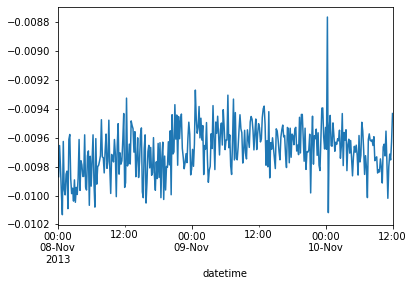

In [27]:
offsetx = rollingmeanvals_1000m['PGFx'] - wrf['PGFx'].sel(height=1000)
offsetx.plot()
meanvals_1000m['PGFx']

0.007205163514638743

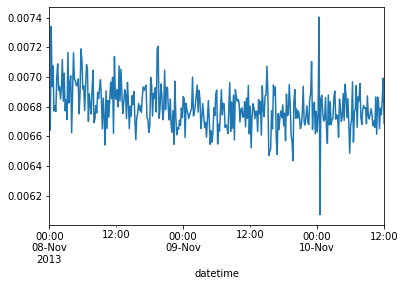

In [28]:
offsety = rollingmeanvals_1000m['PGFy'] - wrf['PGFy'].sel(height=1000)
offsety.plot()
meanvals_1000m['PGFy']

In [29]:
driving_gradient_10min = driving_gradient.unstack().resample('10min').mean().stack()
driving_gradient_10min

dp/dx     dp/dy      PGFx      PGFy
datetime            height                                        
2013-11-08 00:00:00 0.0     0.012673 -0.008778 -0.012673  0.008778
                    10.0    0.011605 -0.008656 -0.011605  0.008656
                    20.0    0.011822 -0.008663 -0.011822  0.008663
                    30.0    0.011576 -0.008549 -0.011576  0.008549
                    40.0    0.011213 -0.008420 -0.011213  0.008420
...                              ...       ...       ...       ...
2013-11-10 12:00:00 1960.0  0.008701 -0.006211 -0.008701  0.006211
                    1970.0  0.008704 -0.006206 -0.008704  0.006206
                    1980.0  0.008707 -0.006200 -0.008707  0.006200
                    1990.0  0.008710 -0.006195 -0.008710  0.006195
                    2000.0  0.008713 -0.006189 -0.008713  0.006189

[72561 rows x 4 columns]

Text(0, 0.5, '$PGF_y$')

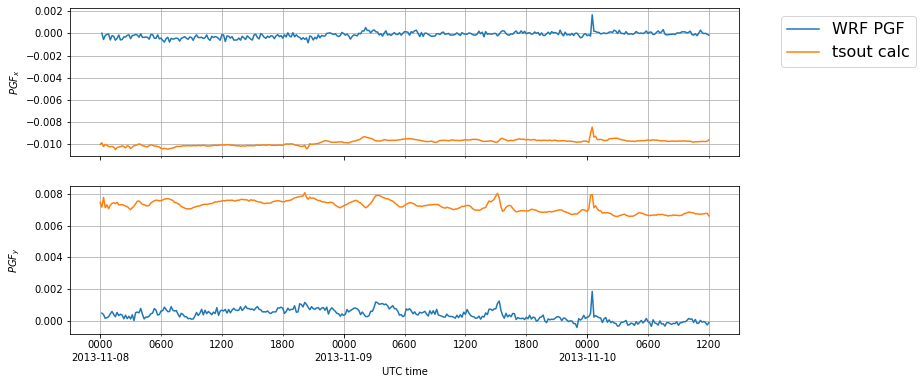

In [30]:
fig,ax = plot_timehistory_at_height(
    {
        'WRF PGF':wrf,
        'tsout calc':driving_gradient_10min,
        #'tsout calc, shifted':driving_gradient_shifted,
    },
    fields=['PGFx','PGFy'],
    heights=1000.,
    datasetkwargs={'tsout calc, shifted':dict(alpha=0.3)},
)
ax[0].set_ylabel('$PGF_x$')
ax[1].set_ylabel('$PGF_y$')
#fig.savefig('estimated_pgf.png',bbox_inches='tight')

In [31]:
wrf[['PGFx','PGFy']].sel(height=driving_gradient.index.levels[1]).resample(Time='1h').mean().to_dataframe()

PGFx      PGFy
Time                height                    
2013-11-08 00:00:00 0.0    -0.000888  0.001497
                    10.0   -0.000865  0.000809
                    20.0    0.000401  0.000563
                    30.0   -0.001371  0.000941
                    40.0   -0.000128 -0.000027
...                              ...       ...
2013-11-10 12:00:00 1960.0 -0.000046  0.000042
                    1970.0 -0.000029  0.000033
                    1980.0 -0.000011  0.000025
                    1990.0  0.000006  0.000016
                    2000.0  0.000024  0.000007

[12261 rows x 2 columns]

In [32]:
hourly_offset = driving_gradient[['PGFx','PGFy']].unstack().resample('1h').mean().stack() \
              - wrf[['PGFx','PGFy']].sel(height=driving_gradient.index.levels[1]).resample(Time='1h').mean().to_dataframe()

In [33]:
hourly_offset

PGFx      PGFy
datetime            height                    
2013-11-08 00:00:00 0.0    -0.011195  0.006900
                    10.0   -0.010654  0.007535
                    20.0   -0.011985  0.007813
                    30.0   -0.010211  0.007471
                    40.0   -0.011092  0.008130
...                              ...       ...
2013-11-10 12:00:00 1960.0 -0.008654  0.006169
                    1970.0 -0.008675  0.006172
                    1980.0 -0.008696  0.006176
                    1990.0 -0.008717  0.006179
                    2000.0 -0.008737  0.006183

[12261 rows x 2 columns]

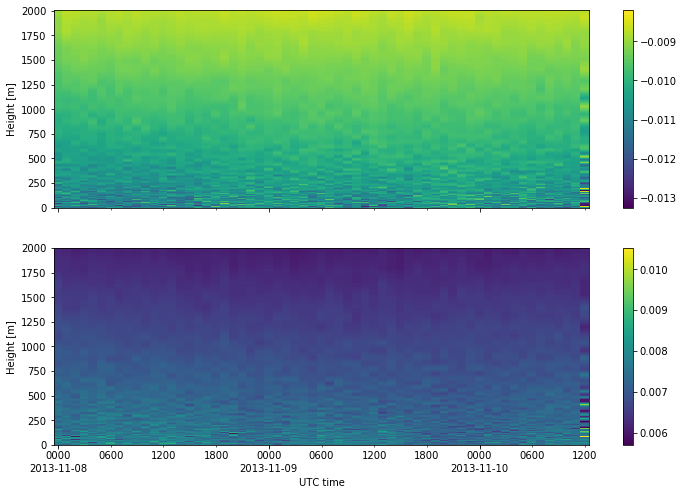

In [34]:
fig,ax,cb = plot_timeheight(hourly_offset,fields=['PGFx','PGFy'])#,
                            #fieldlimits={'PGFx':(-.004,.004),'PGFy':(-.004,.004)},
                            #cmap='RdBu_r')

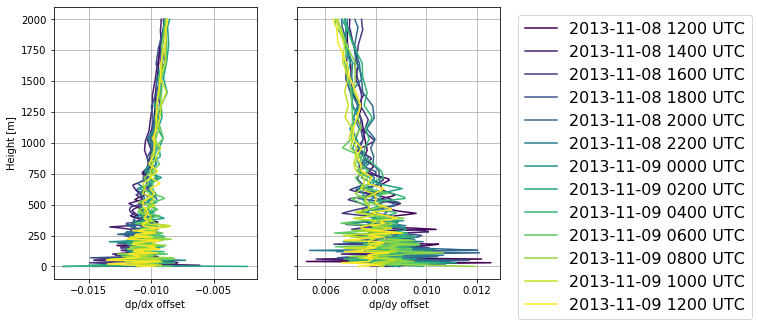

In [35]:
selected_times = pd.date_range('2013-11-08 12:00', '2013-11-09 12:00', freq='2h')
fig,ax = plot_profile(driving_gradient,
                      fields=['PGFx','PGFy'],
                      fieldlabels={'PGFx':'dp/dx offset', 'PGFy':'dp/dy offset'},
                      times=selected_times,
                      cmap='viridis')
fig.savefig('time_varying_gradp_offset_profiles.png', bbox_inches='tight')

### DEBUG: Coriolis?

In [36]:
# Coriolis parameter at the SWiFT site
latitude = 33.61054 # [degrees]
fc = 2 * ( 2*np.pi/(24.0 * 3600.0) ) * np.sin(np.deg2rad(latitude))

In [37]:
ug = ds['u'].sel(nz=100).mean(dim=('ny','nx'))
vg = ds['v'].sel(nz=100).mean(dim=('ny','nx'))

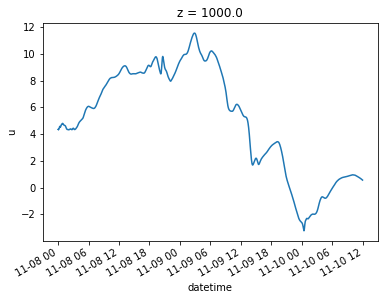

In [38]:
ug.plot()

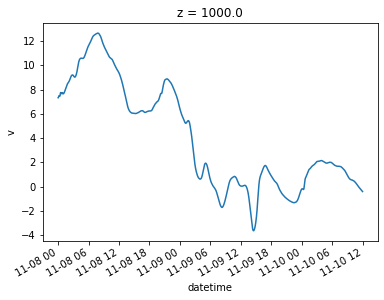

In [39]:
vg.plot()

In [40]:
fc*vg

<xarray.DataArray 'v' (datetime: 21600)>
array([ 5.90331054e-04,  5.90345779e-04,  5.90349184e-04, ...,
       -3.15840558e-05, -3.17021067e-05, -3.18505234e-05])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-11-08T00:00:10 ... 2013-11-10T12:00:00
    z         float64 ...

In [41]:
-fc*ug

<xarray.DataArray 'u' (datetime: 21600)>
array([-3.51015300e-04, -3.51392422e-04, -3.51646024e-04, ...,
       -4.57362143e-05, -4.56649126e-05, -4.55933764e-05])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2013-11-08T00:00:10 ... 2013-11-10T12:00:00
    z         float64 ...

In [42]:
meanvals_1000m

dp/dx    0.009817
dp/dy   -0.007205
PGFx    -0.009817
PGFy     0.007205
Name: 1000.0, dtype: float64

### DEBUG: are the tsout pressures correct?

In [43]:
wrf['pr'] = wrf['P'] + wrf['PB']

In [44]:
ref = ds.isel(nx=1,ny=1).swap_dims({'nz':'height'})
ref = ref.assign_coords({'datetime': ref.coords['datetime'].dt.round(freq='1s')})

In [45]:
ref_i0 = ds.isel(nx=0,ny=1).swap_dims({'nz':'height'}).assign_coords({'datetime': ref.coords['datetime'].dt.round(freq='1s')})
ref_i2 = ds.isel(nx=2,ny=1).swap_dims({'nz':'height'}).assign_coords({'datetime': ref.coords['datetime'].dt.round(freq='1s')})
ref_j0 = ds.isel(nx=1,ny=0).swap_dims({'nz':'height'}).assign_coords({'datetime': ref.coords['datetime'].dt.round(freq='1s')})
ref_j2 = ds.isel(nx=1,ny=2).swap_dims({'nz':'height'}).assign_coords({'datetime': ref.coords['datetime'].dt.round(freq='1s')})

In [ ]:
selected_times = pd.date_range('2013-11-08 12:00', '2013-11-09 12:00', freq='6h')
fig,ax = plot_profile(#{'wrfout':wrf, 'tsout':ref},
                      {
                          'wrfout':wrf,
                          'tsout ( 0, 0)': ref,
                          'tsout (-1, 0)': ref_i0,
                          'tsout (+1, 0)': ref_i2,
                          'tsout ( 0,-1)': ref_j0,
                          'tsout ( 0,+1)': ref_j2,
                      },
                      fields='pr', fieldlabels={'pr':'$p$ [Pa]'},
                      times=selected_times,
                      stack_by_datasets=True,
                      cmap='viridis')
fig.savefig('compare_pr.png',bbox_inches='tight',dpi=150)

In [ ]:
# aliases
wrf['u'] = wrf['U']
wrf['v'] = wrf['V']

In [ ]:
selected_times = pd.date_range('2013-11-08 12:00', '2013-11-09 12:00', freq='6h')
fig,ax = plot_profile(#{'wrfout':wrf, 'tsout':ref},
                      {
                          'wrfout':wrf,
                          'tsout ( 0, 0)': ref,
                          'tsout (-1, 0)': ref_i0,
                          'tsout (+1, 0)': ref_i2,
                          'tsout ( 0,-1)': ref_j0,
                          'tsout ( 0,+1)': ref_j2,
                      },
                      fields=['pr','u','v','theta'], fieldlabels={'pr':'$p$ [Pa]'},
                      times=selected_times,
                      stack_by_datasets=True,
                      datasetkwargs={'wrfout':dict(marker='o',markersize=3,linewidth=0)},
                      cmap='viridis')
fig.savefig('compare_puvt.png',bbox_inches='tight',dpi=150)